<a href="https://colab.research.google.com/github/MojdehAzizian/Chess_Piece_detection/blob/main/ChessPieceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chess Piece Detection

In [1]:
# @title download and unzip dataset
!kaggle datasets download -d krithiik/chess-pieces

Dataset URL: https://www.kaggle.com/datasets/krithiik/chess-pieces
License(s): Community Data License Agreement - Permissive - Version 1.0
 84% 33.0M/39.2M [00:00<00:00, 106MB/s] 
100% 39.2M/39.2M [00:00<00:00, 104MB/s]


In [2]:
import zipfile
import os

zip_file_path = '/content/chess-pieces.zip'
extract_to = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed.")

Extraction completed.


In [20]:
# @title importing libraries

import random
import torch
import numpy as np
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
# @title setting random seed

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title setting device

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


In [9]:
# @title preprocessing data and getting data loaders

dir_iter = os.listdir('/content/all_resized_into_sub_folders_640')
num_classes = 0
for folder in dir_iter:
  num_classes += 1

print(num_classes)

12


In [14]:
transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

dataset = ImageFolder('/content/all_resized_into_sub_folders_640',
                      transform=transform)

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset,
                                                            [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                         shuffle=False)

In [38]:
# @title pre-trained model: resnet18

model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout layer
    nn.Linear(model.fc.in_features, num_classes)
)

model = model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The optimal learning rate is: 0.005463865498818538


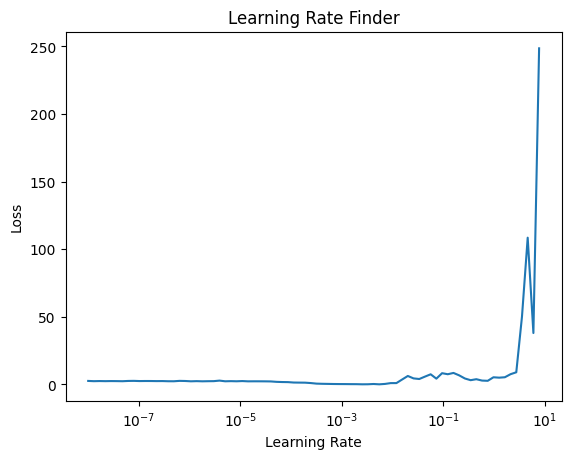

In [34]:
# @title finding optimal learning rate and number of epochs

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt

def find_lr(model, train_loader, criterion, device, num_epochs=1, initial_lr=1e-8, final_lr=10):
    # Prepare to track loss values
    losses = []
    lrs = []
    optimizer = Adam(model.parameters(), lr=initial_lr)

    # Initialize variables for tracking
    min_loss = float('inf')
    optimal_lr = initial_lr  # Start with the initial learning rate

    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Record the learning rate and loss
            current_lr = optimizer.param_groups[0]['lr']
            lrs.append(current_lr)
            losses.append(loss.item())

            # Update the minimum loss and optimal learning rate
            if loss.item() < min_loss:
                min_loss = loss.item()
                optimal_lr = current_lr

            # Update learning rate for the next iteration
            new_lr = initial_lr * (final_lr / initial_lr) ** (len(losses) / (len(train_loader) * num_epochs))
            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr

    return optimal_lr, lrs, losses

# Usage example
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimal_lr, lrs, losses = find_lr(model, train_loader, criterion, DEVICE, num_epochs)

print(f"The optimal learning rate is: {optimal_lr}")

# Plotting the results
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')
plt.show()

In [35]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.epochs_without_improvement} out of {self.patience}')
            if self.epochs_without_improvement >= self.patience:
                return True
        return False

Epoch [1/20], Train Loss: 3.0076, Train Acc: 0.1333, Val Loss: 11813.7202, Val Acc: 0.0833
Epoch [2/20], Train Loss: 2.2791, Train Acc: 0.2208, Val Loss: 9033.2988, Val Acc: 0.1667
Epoch [3/20], Train Loss: 1.8941, Train Acc: 0.2792, Val Loss: 372.5003, Val Acc: 0.0833
Epoch [4/20], Train Loss: 1.7081, Train Acc: 0.3208, Val Loss: 19.2315, Val Acc: 0.1833
Epoch [5/20], Train Loss: 1.6668, Train Acc: 0.4042, Val Loss: 9.7820, Val Acc: 0.1667
Epoch [6/20], Train Loss: 1.4345, Train Acc: 0.4375, Val Loss: 7.0618, Val Acc: 0.0667
Epoch [7/20], Train Loss: 1.3784, Train Acc: 0.4583, Val Loss: 5.0361, Val Acc: 0.2000
Epoch [8/20], Train Loss: 1.2992, Train Acc: 0.4958, Val Loss: 2.4114, Val Acc: 0.3333
Epoch [9/20], Train Loss: 1.2349, Train Acc: 0.5292, Val Loss: 3.7520, Val Acc: 0.1833
Epoch [10/20], Train Loss: 1.2322, Train Acc: 0.5208, Val Loss: 2.7106, Val Acc: 0.3500
Epoch [11/20], Train Loss: 1.0598, Train Acc: 0.5500, Val Loss: 2.9085, Val Acc: 0.4000
Epoch [12/20], Train Loss: 1.15

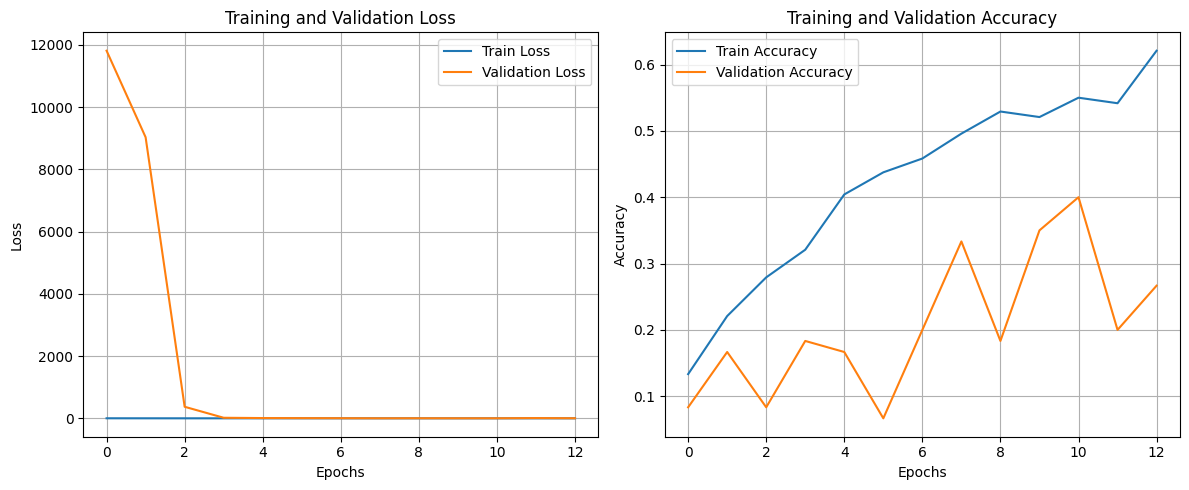

In [39]:
# @title training model

early_stopping = EarlyStopping(patience=5, verbose=True)
optimizer = optim.Adam(model.parameters(), lr=optimal_lr, weight_decay=1e-4)

num_epochs = 20  # Set a higher number for training
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
early_stopping_patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation step
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Implement early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Plots for Loss and Accuracy
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()